# Fetching Up to date forecast

this notebook show a simple way to fetch the up to date forecast of the ARPEGE 0.1° model from the météo France, hosted on [meteo.data.gouv.fr](https://meteo.data.gouv.fr/datasets/65bd13b2eb9e79ab309f6e63).

# TODO : Refocator all of that

In [32]:
import pandas as pd

base_url = "https://object.data.gouv.fr/meteofrance-pnt/pnt/{date}T{time}Z/arpege/01/SP1/arpege__01__SP1__{forecast}__{date}T{time}Z.grib2"

forecast_horizons = ["000H012H", "013H024H"]
date = pd.Timestamp("today").strftime("%Y-%m-%d")
time = "00:00:00"

url = base_url.format(forecast=forecast_horizons[0], date=date, time=time)
print(url)

https://object.data.gouv.fr/meteofrance-pnt/pnt/2024-06-14T00:00:00Z/arpege/01/SP1/arpege__01__SP1__000H012H__2024-06-14T00:00:00Z.grib2


In [33]:
import requests

tmp_dir = "/tmp"
for forecast in forecast_horizons:
    url = base_url.format(forecast=forecast, date=date, time=time)
    print(url)
    filename = f"{tmp_dir}/arpege__01__SP1__{forecast}__{date}T{time}Z.grib2"
    r = requests.get(url, allow_redirects=True)
    open(filename, "wb").write(r.content)

https://object.data.gouv.fr/meteofrance-pnt/pnt/2024-06-14T00:00:00Z/arpege/01/SP1/arpege__01__SP1__000H012H__2024-06-14T00:00:00Z.grib2
https://object.data.gouv.fr/meteofrance-pnt/pnt/2024-06-14T00:00:00Z/arpege/01/SP1/arpege__01__SP1__013H024H__2024-06-14T00:00:00Z.grib2


In [34]:
import xarray as xr

KEYS_FILTER_SSPD = {
    "typeOfLevel": "surface",
    "cfVarName": "ssrd",
}
KEYS_FILTER_WIND = {
    "typeOfLevel": "heightAboveGround",
    "level": 10,
    "cfVarName": "si10",
}
KEYS_FILTER_T2M = {
    "typeOfLevel": "heightAboveGround",
    "level": 2,
    "cfVarName": "t2m",
}

da_suns = []
da_winds = []
for forecast_horizon in forecast_horizons:
    filename = f"{tmp_dir}/arpege__01__SP1__{forecast_horizon}__{date}T{time}Z.grib2"
    da_tmp = xr.open_dataset(
        filename, engine="cfgrib", backend_kwargs={"filter_by_keys": KEYS_FILTER_SSPD}
    ).ssrd
    da_suns.append(da_tmp)
    da_tmp = xr.open_dataset(
        filename, engine="cfgrib", backend_kwargs={"filter_by_keys": KEYS_FILTER_WIND}
    ).si10
    da_winds.append(da_tmp)

da_sun = xr.concat(da_suns, dim="step")
da_wind = xr.concat(da_winds, dim="step")

Ignoring index file '/tmp/arpege__01__SP1__000H012H__2024-06-14T00:00:00Z.grib2.789e2.idx' older than GRIB file
Ignoring index file '/tmp/arpege__01__SP1__000H012H__2024-06-14T00:00:00Z.grib2.d5933.idx' older than GRIB file
Ignoring index file '/tmp/arpege__01__SP1__013H024H__2024-06-14T00:00:00Z.grib2.789e2.idx' older than GRIB file
Ignoring index file '/tmp/arpege__01__SP1__013H024H__2024-06-14T00:00:00Z.grib2.d5933.idx' older than GRIB file


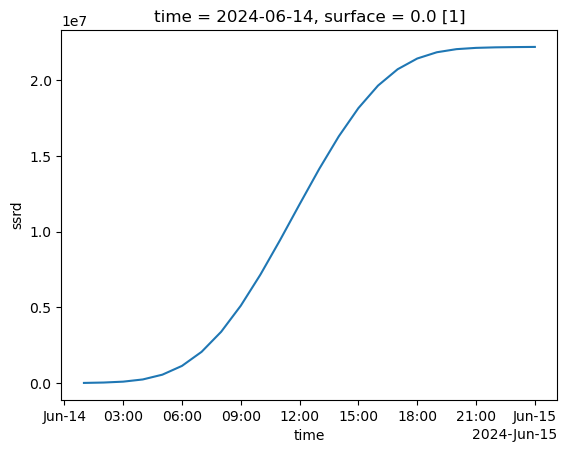

In [35]:
da_sun.mean(["latitude", "longitude"]).plot(x="valid_time")

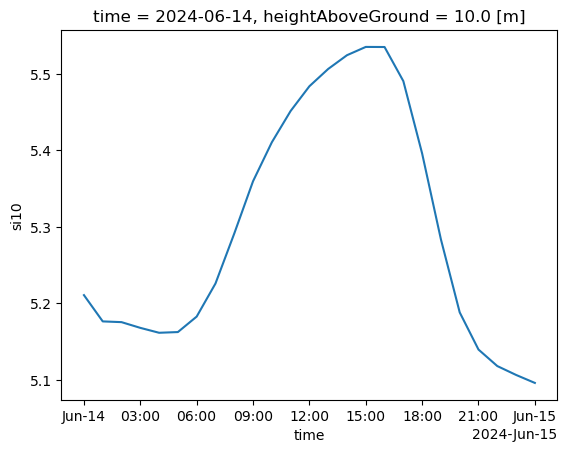

In [36]:
da_wind.mean(["latitude", "longitude"]).plot(x="valid_time")

## Regions Selections

This section shows how to select the regions of interest.

In [43]:
import yaml

filename_bounds = "./france_bounds.yml"
bounds = yaml.safe_load(open(filename_bounds, "r"))
min_lon = bounds["min_lon"]
max_lon = bounds["max_lon"]
min_lat = bounds["min_lat"]
max_lat = bounds["max_lat"]
bounds

{'min_lon': -4.79542,
 'max_lon': 9.55996,
 'min_lat': 41.36484,
 'max_lat': 51.089}

In [48]:
regions_names = yaml.safe_load(open("./regions.yml", "r"))
regions_names

['Île-de-France',
 'Centre-Val de Loire',
 'Bourgogne-Franche-Comté',
 'Normandie',
 'Hauts-de-France',
 'Grand Est',
 'Pays de la Loire',
 'Bretagne',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Auvergne-Rhône-Alpes',
 "Provence-Alpes-Côte d'Azur",
 'Corse']

In [45]:
masks = xr.load_dataarray("./mask_france_regions.nc")
masks

<xarray.DataArray (longitude: 143, latitude: 97)> Size: 111kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
  * latitude   (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4

In [49]:
da_wind_france = da_wind.sel(
    longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat)
)
da_wind_region = da_wind_france.groupby(masks).mean(["latitude", "longitude"])
# relabel the regions groups
da_wind_region["group"] = regions_names
# change the name of the groups
da_wind_region = da_wind_region.rename(group="region")
da_wind_region

<xarray.DataArray 'si10' (step: 25, region: 13)> Size: 1kB
array([[3.633834 , 4.726924 , 2.890073 , 6.462578 , 4.6430645, 2.5707262,
        5.893275 , 4.5465994, 3.987221 , 1.9507447, 3.1654837, 1.6676582,
        2.0362241],
       [3.2270477, 4.5367227, 3.1619112, 5.9841156, 4.9005775, 2.5648384,
        5.5866203, 4.4071183, 4.0192533, 1.9807669, 3.222778 , 1.7768989,
        2.3054676],
       [3.563212 , 4.9562073, 3.6203182, 5.6698127, 5.4124393, 2.6153326,
        5.2358146, 4.3605576, 4.083691 , 1.9310851, 3.28721  , 1.727055 ,
        2.2345347],
       [4.003104 , 5.397727 , 4.08255  , 5.3970237, 5.878717 , 2.577101 ,
        4.7475724, 4.2789207, 4.08367  , 1.8213174, 3.2024512, 1.7382587,
        2.168975 ],
       [4.489919 , 5.513933 , 4.3274903, 5.1862683, 5.875749 , 2.9034426,
        4.276406 , 4.189905 , 4.0086737, 1.8521403, 3.1398833, 1.7972649,
        2.0536613],
       [4.7292566, 5.4604716, 4.472719 , 5.031581 , 5.7862563, 3.5444107,
        3.7230563, 4.0997047, 3.7875435, 1.8912587, 3.2018595, 1.7687811,
        1.945979 ],
       [4.794839 , 5.1926055, 4.6337023, 4.969603 , 5.718553 , 4.10932  ,
        3.7716787, 4.2422333, 3.6012459, 1.8309088, 3.3185728, 1.5955588,
...
        7.831558 , 8.190574 , 4.9081326, 4.0079556, 3.741763 , 2.7064288,
        1.9084607],
       [6.0472727, 6.5705533, 4.2902894, 5.991585 , 4.7212768, 4.5449133,
        7.984231 , 8.034786 , 4.8415146, 3.89688  , 3.526491 , 2.6235993,
        1.3268776],
       [5.4628553, 6.6761065, 4.471928 , 6.7887735, 4.6536603, 4.8045125,
        7.8817663, 7.6242557, 4.7331285, 3.5951288, 3.3250184, 2.6223977,
        1.1473461],
       [5.478565 , 6.6750846, 4.699337 , 7.140038 , 4.5736847, 5.102801 ,
        7.726341 , 6.9882126, 4.671682 , 3.4135349, 3.2307334, 2.6370065,
        1.2340739],
       [6.2646194, 6.649729 , 4.681647 , 7.6925907, 4.961998 , 5.2455564,
        7.3468404, 6.5835176, 4.766712 , 3.3322113, 3.4290023, 2.7505903,
        1.3582473],
       [6.5186   , 6.928161 , 4.544454 , 8.074212 , 5.6381497, 5.2747464,
        6.6815963, 6.314526 , 4.6499653, 3.4512608, 3.813115 , 2.8217368,
        1.4309248],
       [6.653599 , 7.106466 , 4.980348 , 7.927352 , 6.568499 , 5.2746086,
        6.219347 , 5.915178 , 4.480625 , 3.382714 , 4.1069565, 2.831832 ,
        1.6329246]], dtype=float32)
Coordinates:
    time               datetime64[ns] 8B 2024-06-14
  * step               (step) timedelta64[ns] 200B 00:00:00 ... 1 days 00:00:00
    heightAboveGround  float64 8B 10.0
    valid_time         (step) datetime64[ns] 200B 2024-06-14 ... 2024-06-15
  * region             (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

<Axes: title={'center': 'Wind speed at 10m on 2024-06-14'}, xlabel='valid_time'>

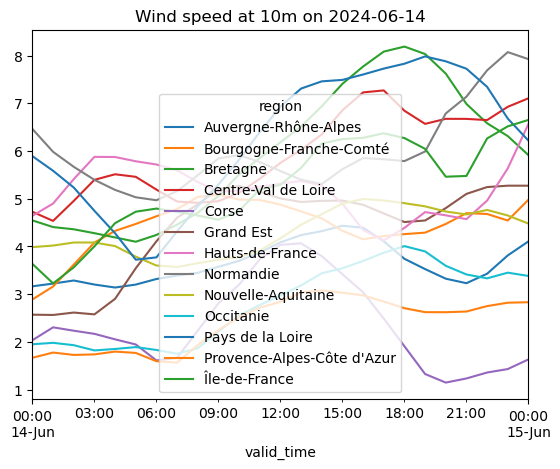

In [120]:
df_wind_regions = da_wind_region.to_dataframe()
df_wind_regions = df_wind_regions.set_index("valid_time", append=True)
# remove the step level
df_wind_regions = df_wind_regions.droplevel("step")
# remove the time level
df_wind = df_wind_regions["si10"].unstack("region")
df_wind.plot(title=f"Wind speed at 10m on {time.date()}")

## Same for the sun

In [81]:
da_sun_france = da_sun.sel(
    longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat)
)
da_sun_region = da_sun_france.groupby(masks).mean(["latitude", "longitude"])
# relabel the regions groups
da_sun_region["group"] = regions_names
# change the name of the groups
da_sun_region = da_sun_region.rename(group="region")
da_sun_region

<xarray.DataArray 'ssrd' (step: 24, region: 13)> Size: 1kB
array([[4.81964017e-11, 4.81964017e-11, 4.81964017e-11, 4.81964017e-11,
        4.81963983e-11, 4.81964017e-11, 4.81964017e-11, 4.81964017e-11,
        4.81964017e-11, 4.81964017e-11, 4.81964017e-11, 4.81964017e-11,
        4.81964017e-11],
       [9.63928035e-11, 9.63928035e-11, 9.63928035e-11, 9.63928035e-11,
        9.63927965e-11, 9.63928035e-11, 9.63928035e-11, 9.63928035e-11,
        9.63928035e-11, 9.63928035e-11, 9.63928035e-11, 9.63928035e-11,
        9.63928035e-11],
       [1.44589216e-10, 1.44589216e-10, 1.44589216e-10, 1.44589216e-10,
        1.44589216e-10, 1.44589216e-10, 1.44589216e-10, 1.44589216e-10,
        1.44589202e-10, 1.44589216e-10, 1.44589216e-10, 1.44589216e-10,
        1.44589216e-10],
       [2.97205475e+02, 1.80127926e+01, 9.15356628e+02, 3.76368561e+01,
        1.25227722e+03, 2.87917822e+03, 1.92882751e-10, 1.92882765e-10,
        1.92882751e-10, 1.92882751e-10, 3.54682861e+02, 3.55898010e+02,
        1.60612769e+03],
       [1.89948496e+04, 1.37849727e+04, 3.67006445e+04, 3.12361621e+04,
        3.71646719e+04, 5.94732539e+04, 2.99723496e+04, 2.79847812e+04,
        1.06043076e+04, 3.34486367e+04, 4.66420820e+04, 1.09222797e+05,
        1.77529188e+05],
...
       [1.65587530e+07, 1.33618860e+07, 9.86733200e+06, 1.46184300e+07,
        1.37320470e+07, 9.72893100e+06, 1.79774720e+07, 1.70122940e+07,
        1.09404450e+07, 1.80745660e+07, 1.50217520e+07, 1.62290090e+07,
        2.73906760e+07],
       [1.65587530e+07, 1.33618860e+07, 9.86733200e+06, 1.46184690e+07,
        1.37320470e+07, 9.72893100e+06, 1.79774720e+07, 1.70136420e+07,
        1.09404450e+07, 1.80745660e+07, 1.50217520e+07, 1.62290090e+07,
        2.73906760e+07],
       [1.65587180e+07, 1.33618780e+07, 9.86734300e+06, 1.46184780e+07,
        1.37320490e+07, 9.72891400e+06, 1.79774640e+07, 1.70136380e+07,
        1.09404370e+07, 1.80745860e+07, 1.50217340e+07, 1.62290220e+07,
        2.73906760e+07],
       [1.65587180e+07, 1.33618780e+07, 9.86734300e+06, 1.46184780e+07,
        1.37320490e+07, 9.72891400e+06, 1.79774640e+07, 1.70136380e+07,
        1.09404370e+07, 1.80745860e+07, 1.50217340e+07, 1.62290220e+07,
        2.73906760e+07],
       [1.65587180e+07, 1.33618780e+07, 9.86734300e+06, 1.46184780e+07,
        1.37320490e+07, 9.72891400e+06, 1.79774640e+07, 1.70136380e+07,
        1.09404370e+07, 1.80745860e+07, 1.50217340e+07, 1.62290220e+07,
        2.73906760e+07]], dtype=float32)
Coordinates:
    time        datetime64[ns] 8B 2024-06-14
  * step        (step) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
    surface     float64 8B 0.0
    valid_time  (step) datetime64[ns] 192B 2024-06-14T01:00:00 ... 2024-06-15
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

<Axes: title={'center': 'Sunshine duration on 2024-06-14'}>

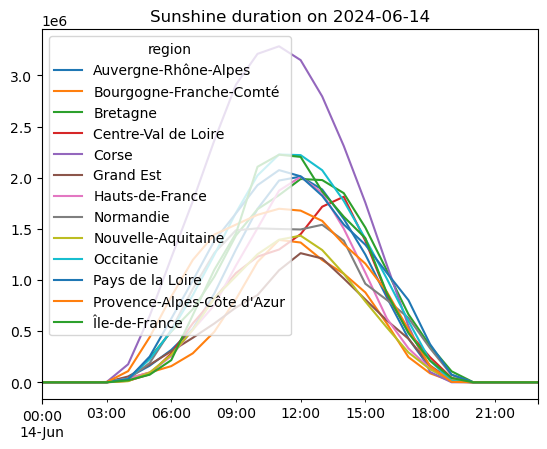

In [115]:
df_sun_regions = da_sun_region.to_dataframe()
df_sun_regions = df_sun_regions.set_index("valid_time", append=True)
df_sun_regions = df_sun_regions.droplevel("step")
df_unstacked = df_sun_regions["ssrd"].unstack("region")

zero_pad = df_unstacked.iloc[0].copy().to_frame().T
zero_pad[:] = 0
zero_pad.index = zero_pad.index - pd.Timedelta("1H")
df_unstacked = pd.concat([zero_pad, df_unstacked], axis=0)
df_instant_flux = df_unstacked.diff().dropna()
df_instant_flux.index -= pd.Timedelta("1H")
df_instant_flux.plot(title=f"Sunshine duration on {time.date()}")

## Prediction of the ENR production

In [116]:
sun_model = pd.read_csv("sun_model_2_params.csv", index_col=0)["0"]
sun_model

Intercept                     12518.539356
auvergne_rhône_alpes             -0.003394
bourgogne_franche_comté           0.007265
bretagne                         -0.005534
centre_val_de_loire               0.006064
corse                            -0.000185
grand_est                         0.003932
hauts_de_france                  -0.004527
normandie                         0.011918
nouvelle_aquitaine                0.024502
occitanie                         0.030147
pays_de_la_loire                 -0.002904
provence_alpes_côte_d_azur        0.010969
île_de_france                    -0.004461
Name: 0, dtype: float64

In [117]:
wind_model = pd.read_csv("wind_model_2_params.csv", index_col=0)["0"]
wind_model

Intercept                    -87065.603543
auvergne_rhône_alpes           6864.873864
bourgogne_franche_comté       -6060.317404
bretagne                       7631.077211
centre_val_de_loire           14372.517590
corse                          -452.219525
grand_est                     17476.839471
hauts_de_france               17141.512065
normandie                      1358.174748
nouvelle_aquitaine             3480.879194
occitanie                      3917.939519
pays_de_la_loire              -2783.430051
provence_alpes_côte_d_azur     -252.119737
île_de_france                 -7465.879598
Name: 0, dtype: float64

<Axes: title={'center': 'Instant production'}>

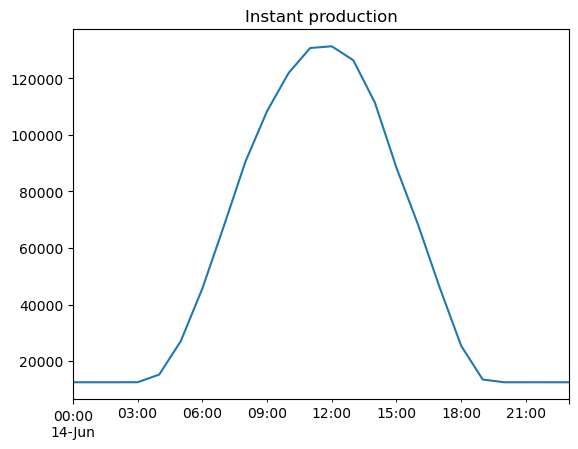

In [119]:
region_names = [
    col.replace(" ", "_").replace("'", "_").replace("-", "_").lower()
    for col in df_instant_flux.columns
]
df_instant_flux.columns = region_names
df_instant_flux["Intercept"] = 1
df_instant_production = df_instant_flux * sun_model
df_instant_production.sum(axis=1).plot(title="Instant production")

<Axes: title={'center': 'Wind production'}, xlabel='valid_time'>

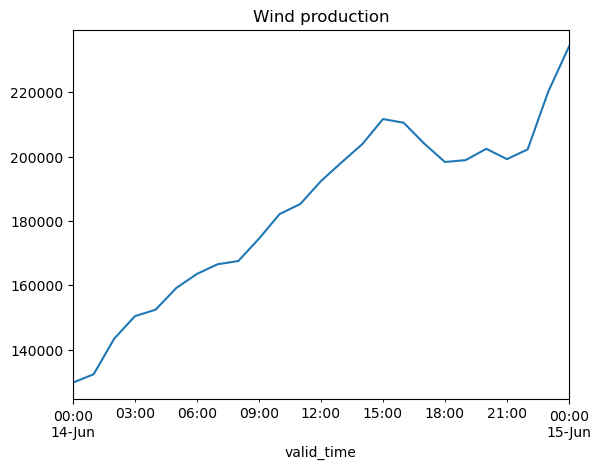

In [122]:
region_names = [
    col.replace(" ", "_").replace("'", "_").replace("-", "_").lower()
    for col in df_wind.columns
]
df_wind.columns = region_names
df_wind["Intercept"] = 1
df_wind_production = df_wind * wind_model
df_wind_production.sum(axis=1).plot(title="Wind production")

## Conclusion

Nous avons vu comment récupérer les prévisions de la météo France pour le modèle ARPEGE 0.1°.

Nous avons vu comment sélectionner les régions et comment calculer les prévisions de production d'énergie renouvelable grâces aux modèles entrainés dans les notebooks précédents.